In [1]:
import Pkg; Pkg.activate(joinpath(@__DIR__)); Pkg.instantiate();
using BilinearControl
using BilinearControl.Problems
using BilinearControl.EDMD
import RobotDynamics as RD
using LinearAlgebra
using RobotZoo
using JLD2
using SparseArrays
using Plots
using Distributions
using Distributions: Normal
using Random
using FiniteDiff, ForwardDiff
using Test

  Activating project at `~/.julia/dev/BilinearControl/examples`


In [2]:
Threads.nthreads()

10

In [3]:
include("learned_models/edmd_utils.jl")

calc_error (generic function with 1 method)

In [4]:
## Visualizer
model = RobotZoo.Cartpole()
include(joinpath(Problems.VISDIR, "visualization.jl"))
vis = Visualizer()
delete!(vis)
set_cartpole!(vis)

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8702
└ @ MeshCat /home/jeonghun/.julia/packages/MeshCat/Ax8pH/src/visualizer.jl:73


MeshCat Visualizer with path /meshcat/robot/cart/pole at http://127.0.0.1:8702

In [5]:
render(vis)

MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("robot" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("rod" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x2f, 0x72, 0x6f, 0x62, 0x6f, 0x74, 0x2f, 0x72, 0x6f, 0x64], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "cart" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("pole" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x2f, 0x63, 0x61, 0x72, 0x74, 0x2f, 0x70, 0x6f, 0x6c, 0x65], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("geom" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("cyl" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x65, 0x2f, 0x67, 0x65, 0x6f, 0x6d, 0x2f, 0x63, 0x79, 0x6c], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "mass" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x2f, 0x67, 0x65, 0x6f, 0x6d, 0x2f, 0x6d, 0x61, 0x73, 0x73], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))), "box" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x74, 0x2f, 0x63, 0x61, 0x72, 0x74, 0x2f, 0x62, 0x6f, 0x78], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "hinge" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x63, 0x61, 0x72, 0x74, 0x2f, 0x68, 0x69, 0x6e, 0x67, 0x65], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))))))), Set{Any}(), ip"127.0.0.1", 8702))

# Generate Data

In [6]:
altro_traj = load(joinpath(Problems.DATADIR, "cartpole_altro_trajectories.jld2"))

X_train_altro = altro_traj["X_train"][:, 1:30]
U_train_altro = altro_traj["U_train"][:, 1:30]
X_test = altro_traj["X_test"][:, 1:10]
U_test = altro_traj["U_test"][:, 1:10]
tf = altro_traj["tf"]
dt = altro_traj["dt"]

times = range(0,tf,step=dt);

In [7]:
model = RobotZoo.Cartpole()  # this model has damping
dmodel = RD.DiscretizedDynamics{RD.RK4}(model);

Random.seed!(1)

# number of trajectories
num_train = 20
num_test = 10

# Generate a stabilizing LQR controller about the top
Qlqr = Diagonal([0.2,10,1e-2,1e-2])
Rlqr = Diagonal([1e-3])
xe = [0,pi,0,0]
ue = [0.0]
ctrl_lqr = LQRController(dmodel, Qlqr, Rlqr, xe, ue, dt)

# Sample a bunch of initial conditions for the LQR controller
x0_sampler = Product([
    Uniform(-1.0,1.0),
    Uniform(pi-pi/3,pi+pi/3),
    Uniform(-.5,.5),
    Uniform(-.5,.5),
])
initial_conditions_lqr = [rand(x0_sampler) for _ in 1:num_train]
initial_conditions_test = [rand(x0_sampler) for _ in 1:num_test]

# Create data set
X_train_lqr, U_train_lqr = create_data(dmodel, ctrl_lqr, initial_conditions_lqr, tf, dt)
X_test_lqr, U_test_lqr = create_data(dmodel, ctrl_lqr, initial_conditions_test, tf, dt);

In [8]:
# X_train = X_train_altro
# U_train = U_train_altro;

X_train = [X_train_altro X_train_lqr]
U_train = [U_train_altro U_train_lqr];

# Fit the Data using normal eDMD
This uses the standard eDMD model method used in the CalTech paper, which learns a model of the form:

$$ x^+ = A x + \sum_{i=1}^m u_i C_i x $$

In [9]:
# Define the basis functions
eigfuns = ["state", "sine", "cosine", "sine", "sine", "chebyshev"]
eigorders = [0,0,0,2,4,4];

In [10]:
# Fit the data
Z_train, Zu_train, kf = build_eigenfunctions(X_train, U_train, eigfuns, eigorders)
F, C, g = learn_bilinear_model(X_train, Z_train, Zu_train,
    ["ridge", "lasso"];
    edmd_weights=[10.1], 
    mapping_weights=[0.0], 
    algorithm=:qr
);

(T, K) = (495000, 2178)
issparse(X) = true
lambda = 10.1
(T, K) = (60000, 132)
issparse(X) = true
lambda = 0.0


### Evaluate the fit
The fit is evaluated using:
$$ \frac{1}{P} \sum_{j=1}^P || g (A \varphi(x_j) + \sum_{i=1}^m u_{j,i} C_i \varphi(x_j)) - x_j^+ || $$

where $y = \varphi(x)$ is the Koopman transform.

In [11]:
err_train = BilinearControl.EDMD.fiterror(F,C,g,kf, X_train, U_train)
err_test = BilinearControl.EDMD.fiterror(F,C,g,kf, X_test, U_test)
println("Train Error: ", err_train)
println("Test Error:  ", err_test)

Train Error: 0.026243805798943632
Test Error:  0.058379562302208886


### Define the Bilinear Model

In [12]:
model_bilinear = EDMDModel(F,C,g,kf,dt,"cartpole")
n,m = RD.dims(model_bilinear)
n0 = originalstatedim(model_bilinear);
println("New state dimension: ", n)

New state dimension: 33


### Compare Linearization
To see if the learned model captures the dynamics, we'll evaluate the effective `A` and `B` dynamics Jaocbians of the learned model on the original dynamics, and compare to the nominal Jacobians.

In [13]:
# Define the equilibrium
xe = [0.,pi,0,0]
ue = [0.0]
ze = RD.KnotPoint{n0,m}(xe,ue,0.0,dt)
ye = expandstate(model_bilinear, xe);

In [14]:
# Nominal Jacobians
J = zeros(n0,n0+m)
xn = zeros(n0)
RD.jacobian!(RD.InPlace(), RD.ForwardAD(), dmodel, J, xn, ze)
A_nom = J[:,1:n0]
B_nom = J[:,n0+1:end];

In [15]:
# Bilinear Jacobians
function dynamics_bilinear(x,u,t,dt)
    y = expandstate(model_bilinear, x)
    yn = zero(y)
    RD.discrete_dynamics!(model_bilinear, yn, y, u, t, dt)
    originalstate(model_bilinear, yn)
end

A_bil = FiniteDiff.finite_difference_jacobian(x->dynamics_bilinear(x,ue,0.0,dt), xe)
B_bil = FiniteDiff.finite_difference_jacobian(u->dynamics_bilinear(xe,u,0.0,dt), ue);

In [16]:
A_nom

4×4 Matrix{Float64}:
 1.0  9.81192e-5  0.01  3.27e-7
 0.0  1.00118     0.0   0.0100039
 0.0  0.0196277   1.0   9.81192e-5
 0.0  0.235532    0.0   1.00118

In [17]:
A_bil

4×4 Matrix{Float64}:
  0.968074    -0.00790191   0.00359882  -0.00453379
  0.00214446   0.998042    -0.00399345   0.00802594
  0.0143793    0.00383764   1.00219     -0.00211818
 -0.0159743    0.206091    -0.00526763   0.997736

In [18]:
B_nom

4×1 Matrix{Float64}:
 5.0001635e-5
 0.00010001962000000002
 0.010000654
 0.020007847999999998

In [19]:
B_bil

4×1 Matrix{Float64}:
 0.0001898356458696071
 1.958012580871582e-5
 0.009686576719104778
 0.019285797054180875

# Train with Derivative Data
Here we incorporate derivative data by penalizing the difference of the Jacobian of the learned model from the expected Jacobians of the nominal model, e.g.:

$$ \sum_{j=1}^P || \frac{\partial}{\partial x} G \hat{f}(\varphi(x_j), u_j) - A_j ||^2 $$

where 

$$ \hat{f}(y,u) = A y + B u + \sum_{i=1}^m u_i C_i y $$

are the learned bilinear dynamics.

In [20]:
# Generate Jacobians
xn = zeros(n0)
jacobians = map(CartesianIndices(U_train)) do cind
    k = cind[1]
    x = X_train[cind]
    u = U_train[cind]
    z = RD.KnotPoint{n0,m}(x,u,times[k],dt)
    J = zeros(n0,n0+m)
    RD.jacobian!(
        RD.InPlace(), RD.ForwardAD(), dmodel, J, xn, z 
    )
    J
end
A_train = map(J->J[:,1:n0], jacobians)
B_train = map(J->J[:,n0+1:end], jacobians)

# Convert states to lifted Koopman states
Y_train = map(kf, X_train)

# Calculate Jacobian of Koopman transform
F_train = map(@view X_train[1:end-1,:]) do x
    sparse(ForwardDiff.jacobian(x->expandstate(model_bilinear,x), x))
end;

### Build Least-squares problem
Find the eDMD data `A`, `B`, and `C` that minimize the following residual:

$$\sum_{j=1}^P (1-\alpha)|| A y_j + B u_j + \sum_{i=1}^m u_{j,i} C_i x_j - y_j^+ ||^2 + 
\alpha || G (A + \sum_{i=1}^m u_{j,i} C_j) F_j  - A_j ||^2 + 
\alpha || G (B + [C_1 x_j \dots C_m x_j]) - B_j ||^2  $$

where $F_j = \partial \varphi(x_j) / \partial x$.

This is equivalent to 

$$ (1-\alpha)|| E Z_{1:P} - Y_{1:P}^+ ||^2 + 
\alpha || G E \hat{A}_{1:P} - A_{1:P} ||^2 +
\alpha || G E \hat{B}_{1:P} - B_{1:P} ||^2 $$

where

$$ E = \begin{bmatrix} A & B & C_1 & \dots & C_m \end{bmatrix} \in \mathbb{R}^{n \times p} $$
$$ Z_j = \begin{bmatrix} 
    x_j \\ u_j \\ u_{j,1} x_j \\ \vdots \\ u_{j,m} x_j 
\end{bmatrix} \in \mathbb{R}^{p}, \quad
\hat{A}_j = \begin{bmatrix} 
    I_n \\ 0_{m,n} \\ u_{j,1} I_n \\ \vdots \\ u_{j,m} I_n 
\end{bmatrix} \in \mathbb{R}^{p \times n}, \quad
\hat{B}_j = \begin{bmatrix} 
    0_{n,m} \\ I_m \\ [x_j \; 0 \; \dots \; 0] \\ \vdots \\ [0 \; \dots \; 0 \; x_j] 
\end{bmatrix} \in \mathbb{R}^{p \times m}
$$

which is equivalent to 

$$ \left\lVert 
\begin{bmatrix} 
    Z_{1:P}^T \otimes I_n \\
    \hat{A}_{1:P}^T \otimes G \\
    \hat{B}_{1:P}^T \otimes G 
\end{bmatrix} \text{vec}(E) - 
\begin{bmatrix}
    \text{vec}{Y_{1:P}^+}\\
    \text{vec}{A_{1:P}^+}\\
    \text{vec}{B_{1:P}^+}\\
\end{bmatrix}
\right\rVert^2 $$

In [21]:
# Create a sparse version of the G Jacobian
G = spdiagm(n0,n,1=>ones(n0)) 
@test norm(G - model_bilinear.g) < 1e-8

# Build Least Squares Problem
W,s = BilinearControl.EDMD.build_edmd_data(
    Z_train, U_train, A_train, B_train, F_train, model_bilinear.g
);

Concatentating data
Creating feature matrix
Creating state Jacobian matrix
Creating control Jacobian matrix
Creating least-squares data


### Solve the Least-squares Problem

In [22]:
@time Wsparse = sparse(W)
@time F = qr(Wsparse)
@time x = F \ s
norm(W*x - s)

 35.736292 seconds (451.15 k allocations: 2.389 GiB, 1.22% gc time, 0.34% compilation time)
147.730944 seconds (627 allocations: 83.927 GiB, 0.60% gc time, 0.01% compilation time)
  5.820438 seconds (33 allocations: 40.744 MiB, 0.14% gc time, 0.05% compilation time)


37931.69364928344

In [23]:
# Extract out bilinear dynamics
n = length(Z_train[1])
E = reshape(x,n,:)
A = E[:,1:n]
B = E[:,n .+ (1:m)]
C = E[:,n+m .+ (1:n*m)];

In [24]:
# Evaluate the Fit
err_train2 = BilinearControl.EDMD.fiterror(A,B,C,g,kf, X_train, U_train)
err_test2 = BilinearControl.EDMD.fiterror(A,B,C,g,kf, X_test, U_test)
println("Train Error: ", err_train)
println("Test Error:  ", err_test)
println("New Train Error: ", err_train2)
println("New Test Error:  ", err_test2)

Train Error: 0.026243805798943632
Test Error:  0.058379562302208886
New Train Error: 0.02347627570144455
New Test Error:  0.06186634653569404


In [25]:
BilinearControl.matdensity(Wsparse)

0.1292593635595607

In [26]:
# Save data
jldsave(joinpath(Problems.DATADIR,"cartpole_eDMD_jac_tvlqr_data.jld2"); A, B, C, g, kf, eigfuns, eigorders, tf, dt)

### Create and Test new eDMD Model

In [27]:
# import test trajectories
altro_traj = load(joinpath(Problems.DATADIR, "cartpole_altro_trajectories.jld2"))
X_test = altro_traj["X_test"]
U_test = altro_traj["U_test"];

In [28]:
cartpole_data = load(joinpath(Problems.DATADIR, "cartpole_eDMD_jac_tvlqr_data.jld2"))
A = cartpole_data["A"]
B = cartpole_data["B"]
C = cartpole_data["C"]
g = cartpole_data["g"]
kf = cartpole_data["kf"]
tf = cartpole_data["tf"]
dt = cartpole_data["dt"]

model_bilinear2 = EDMDModel(A,B,[C],g,kf,dt,"cartpole")
n,m = RD.dims(model_bilinear2)
n0 = originalstatedim(model_bilinear2)
times = range(0,tf,step=dt)

# create cartpole model
model = RobotZoo.Cartpole()
dmodel = RD.DiscretizedDynamics{RD.RK4}(model);

# Define the equilibrium
xe = [0.0,pi,0.0,0.0]
ue = [0.0]
ze = RD.KnotPoint{n0,m}(xe,ue,0.0,dt)

# Nominal Jacobians
J = zeros(n0,n0+m)
xn = zeros(n0)
RD.jacobian!(RD.InPlace(), RD.ForwardAD(), dmodel, J, xn, ze)
A_nom = J[:,1:n0]
B_nom = J[:,n0+1:end];

In [29]:
# Get A,B for new system
function dynamics_bilinear2(x,u,t,dt)
    y = expandstate(model_bilinear2, x)
    yn = zero(y)
    RD.discrete_dynamics!(model_bilinear2, yn, y, u, t, dt)
    originalstate(model_bilinear2, yn)
end

A_bil2 = FiniteDiff.finite_difference_jacobian(x->dynamics_bilinear2(x,ue,0.0,dt), xe)
B_bil2 = FiniteDiff.finite_difference_jacobian(u->dynamics_bilinear2(xe,u,0.0,dt), ue);

**Compare the Jacobians with Nominal model**

In [30]:
A_nom

4×4 Matrix{Float64}:
 1.0  9.81192e-5  0.01  3.27e-7
 0.0  1.00118     0.0   0.0100039
 0.0  0.0196277   1.0   9.81192e-5
 0.0  0.235532    0.0   1.00118

In [31]:
A_bil2

4×4 Matrix{Float64}:
  1.0          9.61104e-5   0.0100007    2.18366e-7
 -1.66893e-6   1.00117     -2.71201e-6   0.0100029
 -6.83218e-6   0.0192338    1.00015      5.07012e-5
 -0.000342578  0.233975    -0.000508785  1.00089

In [32]:
B_nom

4×1 Matrix{Float64}:
 5.0001635e-5
 0.00010001962000000002
 0.010000654
 0.020007847999999998

In [33]:
B_bil2

4×1 Matrix{Float64}:
 4.993066579572769e-5
 9.882450103759766e-5
 0.009996284898079466
 0.019772949555772357

### Stabilize with LQR

In [34]:
Qlqr = Diagonal([0.2,10,1e-2,1e-2])
Rlqr = Diagonal([1e-2])
K_nom = dlqr(A_nom, B_nom, Qlqr, Rlqr)
K_bil2 = dlqr(A_bil2, B_bil2, Qlqr, Rlqr);

In [35]:
# Evaluate stability
isstable_nominal = maximum(abs.(eigvals(A_nom - B_nom*K_nom))) < 1.0
isstable_bilinear2 = maximum(abs.(eigvals(A_bil2 - B_bil2*K_bil2))) < 1.0
isstable_nominal_with_bilinear2 = maximum(abs.(eigvals(A_nom - B_nom*K_bil2))) < 1.0

println("Stability Summary:")
println("  Dynamics  |  Controller  |  is stable? ")
println("------------|--------------|--------------")
println("  Nominal   |  Nominal     |  ", isstable_nominal)
println("  Bilinear  |  Bilinear    |  ", isstable_bilinear2)
println("  Nominal   |  Bilinear    |  ", isstable_nominal_with_bilinear2)

Stability Summary:
  Dynamics  |  Controller  |  is stable? 
------------|--------------|--------------
  Nominal   |  Nominal     |  true
  Bilinear  |  Bilinear    |  true
  Nominal   |  Bilinear    |  true


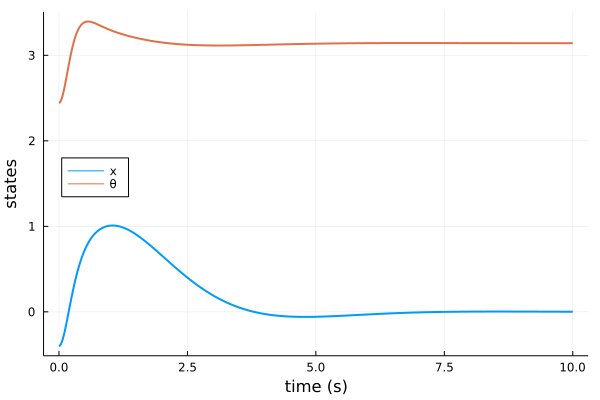

In [36]:
ctrl_lqr2 = LQRController(K_bil2, xe, ue)
t_sim = 10.0
times_sim = range(0,t_sim,step=dt)
x0 = [-0.4,pi-deg2rad(40),0,0]
Xsim_lqr2, = simulatewithcontroller(dmodel, ctrl_lqr2, x0, t_sim, dt)
plotstates(times_sim, Xsim_lqr2, inds=1:2, xlabel="time (s)", ylabel="states", label=["x" "θ"], legend=:left, lw=2)

In [37]:
render(vis)

MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("robot" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("rod" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x2f, 0x72, 0x6f, 0x62, 0x6f, 0x74, 0x2f, 0x72, 0x6f, 0x64], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "cart" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("pole" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x2f, 0x63, 0x61, 0x72, 0x74, 0x2f, 0x70, 0x6f, 0x6c, 0x65], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("geom" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("cyl" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x65, 0x2f, 0x67, 0x65, 0x6f, 0x6d, 0x2f, 0x63, 0x79, 0x6c], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "mass" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x2f, 0x67, 0x65, 0x6f, 0x6d, 0x2f, 0x6d, 0x61, 0x73, 0x73], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))), "box" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x74, 0x2f, 0x63, 0x61, 0x72, 0x74, 0x2f, 0x62, 0x6f, 0x78], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "hinge" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x63, 0x61, 0x72, 0x74, 0x2f, 0x68, 0x69, 0x6e, 0x67, 0x65], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))))))), Set(Any[WebSocket(server, CONNECTED), WebSocket(server, CONNECTED), WebSocket(server, CONNECTED)]), ip"127.0.0.1", 8702))

In [38]:
visualize!(vis, model, t_sim, Xsim_lqr2)

### Tracking with TVLQR

In [39]:
# # Extract Reference Trajectory
# X_ref = vec(Matrix(map(x -> vec(x), X_test[:,1]')))
# U_ref = vec(Matrix(map(u -> vec(u), U_test[:,1]')))

# # Linearize in Koopman Space
# Z_ref = map(x -> expandstate(model_bilinear2, x), X_ref)
# A, B = linearize(model_bilinear2, Z_ref, U_ref, times)

# # TVLQRController
# Qtvlqr = [Diagonal(1e-2*ones(n)) for knot in 1:num_knot]
# Rtvlqr = [Diagonal([1e-4]) for knot in 1:num_knot]

# # Simulate with controller
# ctrl_tvlqr = TVLQRController(A,B,Qtvlqr,Rtvlqr, Z_ref, U_ref, times)
# t_sim = 3
# times_sim = range(0,t_sim,step=dt)
# z0 = Z_ref[1]
# Zsim_tvlqr, = simulatewithcontroller(model_bilinear2, ctrl_tvlqr, z0, t_sim, dt)
# Xsim_tvlqr_koopman = map(z -> originalstate(model_bilinear2, z), Zsim_tvlqr)
# plotstates(times, X_ref, inds=1:2, xlabel="time (s)", ylabel="states", label=["x (reference)" "θ (reference)"], legend=:top, lw=2)
# plotstates!(times_sim, Xsim_tvlqr_koopman, inds=1:2, xlabel="time (s)", ylabel="states", label=["x (TVLQR)" "θ (TVLQR)"], legend=:top, lw=2)

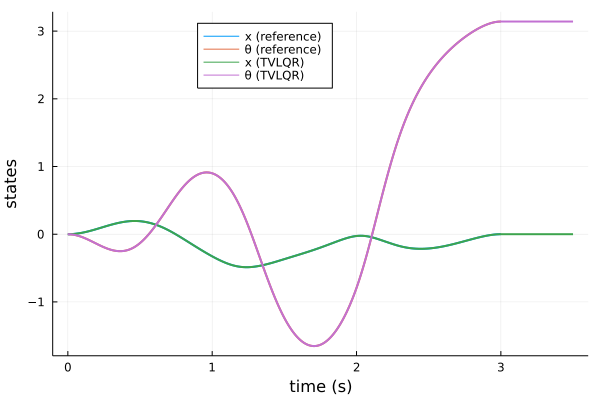

In [44]:
X_ref = vec(Matrix(map(x -> vec(x), X_test[:,2]')))
U_ref = vec(Matrix(map(u -> vec(u), U_test[:,2]')))

push!(X_ref, [0.0, pi, 0.0, 0.0])
push!(U_ref, [0.0])

num_knot = length(X_ref)
uN = length(U_ref)

A = [zeros(n,n) for k = 1:uN]
B = [zeros(n,m) for k = 1:uN]

for k in 1:uN
    A[k] = FiniteDiff.finite_difference_jacobian(x -> dynamics_bilinear2(x, U_ref[k], 0.0, dt), X_ref[k])
    B[k] = FiniteDiff.finite_difference_jacobian(u -> dynamics_bilinear2(X_ref[k], u, 0.0, dt), U_ref[k])
end

Qtvlqr = [Diagonal([0.2,10,1e-2,1e-2]) for k in 1:num_knot]
Rtvlqr = [Diagonal([1]) for k in 1:num_knot]

tvlqr_ctrl = TVLQRController(A, B, Qtvlqr, Rtvlqr, X_ref, U_ref, times)
t_sim = 3.5
times_sim = range(0,t_sim,step=dt)
x0 = [0.0, 0.0, 0.0, 0.0]

Xsim_tvlqr, = simulatewithcontroller(dmodel, tvlqr_ctrl, x0, t_sim, dt)
plotstates(times, X_ref[1:end-1], inds=1:2, xlabel="time (s)", ylabel="states", label=["x (reference)" "θ (reference)"], legend=:top, lw=2)
plotstates!(times_sim, Xsim_tvlqr, inds=1:2, xlabel="time (s)", ylabel="states", label=["x (TVLQR)" "θ (TVLQR)"], legend=:top, lw=2)

In [41]:
render(vis)

MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), UInt8[0x83, 0xa7, 0x6f, 0x70, 0x74, 0x69, 0x6f, 0x6e, 0x73, 0x82  …  0x5f, 0x61, 0x6e, 0x69, 0x6d, 0x61, 0x74, 0x69, 0x6f, 0x6e], Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("robot" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("rod" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x2f, 0x72, 0x6f, 0x62, 0x6f, 0x74, 0x2f, 0x72, 0x6f, 0x64], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "cart" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("pole" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x2f, 0x63, 0x61, 0x72, 0x74, 0x2f, 0x70, 0x6f, 0x6c, 0x65], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("geom" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("cyl" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x65, 0x2f, 0x67, 0x65, 0x6f, 0x6d, 0x2f, 0x63, 0x79, 0x6c], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "mass" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x2f, 0x67, 0x65, 0x6f, 0x6d, 0x2f, 0x6d, 0x61, 0x73, 0x73], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))), "box" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x74, 0x2f, 0x63, 0x61, 0x72, 0x74, 0x2f, 0x62, 0x6f, 0x78], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "hinge" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x63, 0x61, 0x72, 0x74, 0x2f, 0x68, 0x69, 0x6e, 0x67, 0x65], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))))))), Set(Any[WebSocket(server, CONNECTED), WebSocket(server, CONNECTED), WebSocket(server, CONNECTED)]), ip"127.0.0.1", 8702))

In [42]:
visualize!(vis, model, t_sim, Xsim_tvlqr)